# tokenize

> Fill in a module description here

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| default_exp tokenize

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import math
import json

import faiss
import pandas as pd
from fastai.vision.all import *

from singleline_stroke3.embeddings import *
from singleline_stroke3.display import *
from singleline_stroke3.transforms import *
from singleline_stroke3.fileorg import *

In [ ]:
EXTERNAL_PARENT_DIR = Path('/Users/al/Dropbox/2-Areas/2-Sketchbooks')
EXTERNAL_SKETCHBOOKS_DIR = EXTERNAL_PARENT_DIR / 'sketchbooks'
EXTERNAL_DATA_HOME = EXTERNAL_PARENT_DIR / 'singleline_data'

EPOCH = SketchbookEpoch(epoch='20240104', data_home=EXTERNAL_DATA_HOME)

no env var SINGLELINE_DATA_HOME, defaulting to: None


In [ ]:
THRESHOLDED_OUTPUT_DIR = EPOCH.dir_08_THRESHOLDED()
THESHOLDED_TSV_FNAME = EPOCH.tsv_08_THRESHOLDED()
fjdf = pd.read_csv(THESHOLDED_TSV_FNAME, delimiter="\t", index_col="idx")
fjdf.head()

,new_idx,group_fname,group_id,group_num_strokes,group_num_points,indiv_fnamebboxsep_,orig_fname,labelbboxsep_,handlabeled_path,is_new,...,err_msg,indiv_fname,label,emb_csv,knn_dist,knn_clusterid,knn_label,cluster_label,rdp_num_points,rdp_epsilon
idx,,,,,,,,,,,,,,,,,,,,,
0,0,0_drawings/sb55p003g00.png,0,4,1510,sb55p003.jpg,art/sb55p003.jpg,art,0_drawings/sb55p003.jpg,False,...,NaN,sb55p003g00.png,0_drawings,"0.04728329,-0.5714155,-0.73929733,-0.35399058,0.22400337,-0.65341413,0.11710799,-0.4896673,-0.7537334,-0.27084306,-0.43680793,-0.72562873,0.26104796,-0.6266761,-0.68991846,-0.57515705,-0.5467274,-0.6520286,2.2132683,-0.63401383,-0.64108604,0.0068377256,-0.5446661,-0.6779002,-0.40022308,-0.6690378,-0.25018138,-0.5982413,-0.73986673,1.0058696,-0.68509877,-0.67007643,0.5276551,-0.4592305,-0.600525,-0.3091834,-0.73933,-0.57338566,0.84570634,-0.6179389,-0.52985966,0.5803701,0.10534239,-0.6682474,-0.1908136,-0.59257406,-0.6157326,-0.6001429,1.3485551,1.1220317,0.10932493,-0.66552746,0.8113811,1....",196.44476,14,NaN,good,1510,0.0
1,1,0_drawings/sb73p061g00.png,0,2,128,sb73p061.jpg,art/sb73p061.jpg,art,0_drawings/sb73p061.jpg,False,...,NaN,sb73p061g00.png,0_drawings,"-0.6198182,-0.5714155,-0.73929733,-0.6553513,-0.6254566,-0.65341413,-0.7267234,-0.46724933,-0.7537334,0.9455167,-0.62038505,-0.72562873,0.18925023,-0.6266761,0.33996195,-0.15316445,-0.5467274,0.03829068,1.0683823,0.23568732,-0.64108604,-0.55193967,-0.5446661,-0.022136033,1.4963098,-0.4510746,-0.4518578,-0.5982413,-0.28755826,0.1980134,-0.68509877,-0.67007643,-0.52171326,-0.19965711,-0.0069928765,-0.46161294,-0.73933,-0.50798476,0.03861904,0.68692446,-0.5830822,0.46990138,1.1344135,-0.6682474,0.6321523,-0.59257406,0.156174,-0.6001429,2.36085,0.16527855,-0.13570255,-0.63657653,0.61075664,0.7...",119.71115,10,NaN,good,128,0.0
5,5,0_drawings/sb73p041g00.png,0,3,702,sb73p041.jpg,art/sb73p041.jpg,art,0_drawings/sb73p041.jpg,False,...,NaN,sb73p041g00.png,0_drawings,"-0.6198182,-0.5714155,-0.73929733,-0.6553513,-0.4395254,-0.65341413,-0.7267234,-0.30100727,-0.7537334,0.6979399,0.5823597,-0.72562873,-0.662768,0.702158,-0.6232817,-0.57515705,-0.22156492,-0.07576728,-0.25915077,0.7949797,-0.5030652,-0.55193967,-0.5446661,-0.6779002,-0.57759243,-0.6690378,-0.4518578,0.8875855,-0.73986673,0.2878165,-0.68509877,-0.67007643,-0.52171326,-0.20293939,-0.600525,0.28690326,-0.73933,0.13321829,-0.65925777,-0.6179389,-0.61049384,-0.58021957,-0.6189488,-0.6682474,-0.75794554,-0.59257406,0.2206502,-0.6001429,-0.3428496,-0.37840372,-0.59497476,-0.66552746,-0.6482407,0....",285.93152,8,NaN,good,702,0.0
6,6,0_drawings/sb73p041g01.png,1,1,205,sb73p041.jpg,art/sb73p041.jpg,art,0_drawings/sb73p041.jpg,False,...,NaN,sb73p041g01.png,0_drawings,"-0.6198182,-0.5714155,-0.73929733,-0.6553513,0.058876395,-0.65341413,-0.7267234,-0.42173523,-0.7537334,0.7433976,0.19966531,-0.72562873,0.62771916,-0.6266761,-0.68991846,-0.57515705,-0.5467274,1.5417054,2.402433,-0.6497359,-0.64108604,-0.4386818,-0.5446661,-0.6779002,-0.57759243,-0.6690378,-0.4518578,0.11702931,-0.73986673,-0.45211998,-0.68509877,-0.67007643,-0.52171326,0.34430972,-0.48163074,-0.6186755,-0.73933,0.040438354,-0.65925777,0.7474549,-0.61049384,0.30740798,1.8930382,-0.6682474,-0.75794554,-0.59257406,-0.3586682,0.89375025,-0.651804,0.08712256,1.415978,-0.66552746,-0.6482407,-0....",179.57721,8,NaN,good,205,0.0
10,10,0_drawings/sb55p080g00.png,0,4,1462,sb55p080.jpg,art/sb55p080.jpg,art,0_drawings/sb55p080.jpg,False,...,NaN,sb55p080g00.png,0_drawings,"-0.6198182,-0.5714155,-0.12864059,-0.6553513,0.03367281,-0.3521561,-0.7267234,-0.47485968,-0.7537334,-0.42715576,1.136474,-0.72562873,2.6017675,-0.6266761,-0.68991846,-0.57515705,-0.5467274,1.0752423,-0.02930379,1.118658,0.39956325,-0.55193967,-0.5446661,-0.6779002,-0.57759243,-0.6690378,-0.4518578,0.16788304,-0.42450532,-0.45211998,-0.68509877,-0.67007643,-0.23189741,0.37339267,1.0403941,0.11935049,-0.73933,-0.19533288,1.3258636,-0.53331745,-0.61049384,1.4947255,0.25517285,-0.59559596,-0.75794554,-0.5

In [ ]:
THRESHOLDED_NPZ_ALL = THRESHOLDED_OUTPUT_DIR / 'furtherfiltered_all.npz'
ds = np.load(THRESHOLDED_NPZ_ALL, encoding='latin1', allow_pickle=True)['arr_0']
print(f"num drawings in dataset: {ds.shape[0]}")

num drawings in dataset: 1550


In [ ]:
# stack all drawings, to get one big array of all the stroke3 steps in the dataset
all_steps = np.vstack(ds).astype(np.float32)
print(f"num individual steps in all strokes in dataset: {all_steps.shape[0]}")

num individual steps in all strokes in dataset: 315396


In [ ]:
zero_indices = []
one_indices = []
for idx, is_zero in enumerate(all_steps[:,2]==0):
    if is_zero:
        zero_indices.append(idx)
    else:
        one_indices.append(idx)

zero_steps = all_steps[zero_indices]
one_steps = all_steps[one_indices]

print(f"num steps with lift_pen=0: {zero_steps.shape[0]}")
print(f"num steps with lift_pen=1: {one_steps.shape[0]}")

num steps with lift_pen=0: 312557
num steps with lift_pen=1: 2839


In [ ]:
kmeans_zero = train_kmeans(zero_steps, ncentroids=960, nredo=10, seed=42)
kmeans_one = train_kmeans(one_steps, ncentroids=40, nredo=10, seed=42)

In [ ]:
#kmeans_zero.centroids

In [ ]:
# kmeans_one.centroids

In [ ]:
#| export
class Stroke3Tokenizer(object):

    def __init__(self, centroids_zero, centroids_one):
        self.centroids_zero = centroids_zero
        print(self.centroids_zero.shape)
        self.kmeans_zero = faiss.IndexFlatL2(self.centroids_zero.shape[1])
        self.kmeans_zero.add(self.centroids_zero)

        self.centroids_one = centroids_one
        self.kmeans_one = faiss.IndexFlatL2(self.centroids_one.shape[1])
        self.kmeans_one.add(self.centroids_one)

    def save(self, base_dir, extra_suffix=""):
        CENTROIDS_FNAME = base_dir / f"stroke3_centroids{extra_suffix}.json"
        with open(CENTROIDS_FNAME, 'w') as outfile:
            payload = {
                'centroids_zero': self.centroids_zero.tolist(),
                'centroids_one': self.centroids_one.tolist(),
            }
            json.dump(payload, outfile, indent=2)
        print(f"wrote {CENTROIDS_FNAME}")

    @staticmethod
    def load(base_dir, extra_suffix=""):
        CENTROIDS_FNAME = base_dir / f"stroke3_centroids{extra_suffix}.json"
        with open(CENTROIDS_FNAME, 'r') as infile:
            payload = json.load(infile)
        centroids_zero = np.array(payload['centroids_zero'], dtype=np.float32)
        centroids_one = np.array(payload['centroids_one'], dtype=np.float32)

        tokenizer = Stroke3Tokenizer(centroids_zero, centroids_one)
        return tokenizer

    def encode(self, input_deltas):
        """
        total vocabulary size is len(centroids_zero) + len(centroids_one).

        for a point with lift_pen=0, the "word" index in the vocabulary
        is equal to its position within the centroids_zero list.

        for a point with lift_pen=1, the "word" index in the vocabulary
        is equal to its position within the centroids_one list, PLUS
        the total length of the centroids_zero list.
        """
        D0, I0 = self.kmeans_zero.search(input_deltas, 1)
        D1, I1 = self.kmeans_one.search(input_deltas, 1)
        
        tokens = []
        for idx in range(input_deltas.shape[0]):
            row = input_deltas[idx]
            if row[2] == 0:
                tokens.append(I0[idx][0])
            elif row[2] == 1:
                tokens.append(I1[idx][0] + self.centroids_zero.shape[0])
            else:
                raise Exception ('didnt find a 0 or 1 in the lift_pen column')
        return tokens

    def decode(self, tokens):
        num_zero = self.centroids_zero.shape[0]
        num_one = self.centroids_one.shape[0]
        decoded = []
        for tok in tokens:
            if tok < 0:
                raise Exception("invalid token index")
            if tok < num_zero:
                decoded.append(self.centroids_zero[tok])
            elif tok < (num_zero + num_one):
                decoded.append(self.centroids_one[tok - num_zero])
            else:
                raise Exception("invalid token index")
        return np.array(decoded)
            

In [ ]:
# t = Stroke3Tokenizer(kmeans_zero.centroids, kmeans_one.centroids)
# t.save(THRESHOLDED_OUTPUT_DIR)

In [ ]:
tokenizer = Stroke3Tokenizer.load(THRESHOLDED_OUTPUT_DIR)

(2048, 3)


In [ ]:
test_toks = tokenizer.encode(ds[2])

In [ ]:
test_toks[0:5]

[1635, 1251, 1393, 1013, 671]

In [ ]:
test_decoded = tokenizer.decode(test_toks)
test_decoded[:5]

array([[ 0.3155888, 37.36093  ,  0.       ],
       [ 7.065908 , -8.754673 ,  0.       ],
       [-1.8780638,  6.4204984,  0.       ],
       [ 4.526787 ,  4.7838955,  0.       ],
       [ 4.9135633, 11.580178 ,  0.       ]], dtype=float32)

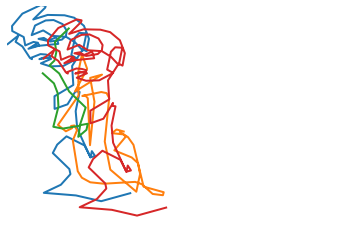

In [ ]:
plot_strokes(deltas_to_strokes(test_decoded))

In [ ]:
tokenizer.centroids_zero

array([[ 0.6209417 , -0.33721057,  0.        ],
       [-4.1855707 , -3.1003277 ,  0.        ],
       [ 5.7066207 ,  2.6960166 ,  0.        ],
       ...,
       [-1.1269675 , -0.28028095,  0.        ],
       [-3.6861207 , -4.5447764 ,  0.        ],
       [-1.6025403 ,  0.5354872 ,  0.        ]], dtype=float32)

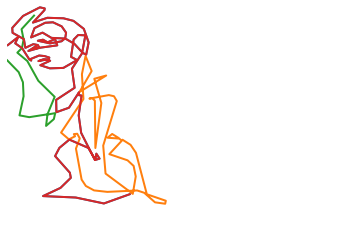

In [ ]:
plot_strokes(deltas_to_strokes(ds[2]))

In [ ]:
deltas_tmp = ds[2]

In [ ]:
deltas_tmp.shape

(242, 3)

In [ ]:
deltas_tmp[:5]

array([[ 0.3771549 , 38.41915779,  0.        ],
       [ 6.84299279, -8.26956107,  0.        ],
       [-1.94953761,  6.4101698 ,  0.        ],
       [ 4.55352531,  4.95268558,  0.        ],
       [ 4.70517464, 11.38796166,  0.        ]])

In [ ]:
D0, I0 = kmeans_zero.index.search(deltas_tmp, 1)
D1, I1 = kmeans_one.index.search(deltas_tmp, 1)

S0 = kmeans_zero.centroids[I0]
S1 = kmeans_one.centroids[I1]


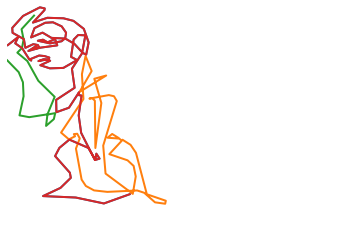

In [ ]:
plot_strokes(deltas_to_strokes(deltas_tmp))

In [ ]:
tokenized_steps = []
for idx in range(deltas_tmp.shape[0]):
    row = deltas_tmp[idx]
    if row[2] == 0:
        tokenized_steps.append(S0[idx][0])
    elif row[2] == 1:
        tokenized_steps.append(S1[idx][0])
    else:
        raise Exception ('didnt find a 0 or 1 in the lift_pen column')

new_deltas = np.array(tokenized_steps)

In [ ]:
new_deltas[0:5]

array([[-3.3815517, 40.04465  ,  0.       ],
       [ 6.9500613, -8.3709345,  0.       ],
       [-1.9793537,  6.5232167,  0.       ],
       [ 4.097289 ,  4.915239 ,  0.       ],
       [ 4.9076104, 11.547217 ,  0.       ]], dtype=float32)

In [ ]:
len(new_deltas)

242

In [ ]:
len(deltas_tmp)

242

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()